## Pré: Conexão com Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Etapa 1: Instalação das dependências

In [2]:
!pip install tensorflow-gpu==2.1.0
!pip install tqdm
!pip install kaggle
!pip install keras-rectified-adam
#!pip install tensorflow-addons
!pip install tfa-nightly

     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 3.8MB 49.2MB/s 
     |████████████████████████████████| 450kB 45.6MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exis

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=706a39fa8448397300fd3e04d9a5bfcd73f25c39f41c3706014f2ba5a983cbb6
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam
     |████████████████████████████████| 1.0MB 4.9MB/s 


### Importação das bibliotecas

In [3]:
import zipfile
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import pandas as pd
import sys
import itertools
from keras_radam import RAdam
import shutil

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
tf.__version__

Using TensorFlow backend.


'2.1.0'

### Otimizações tensorflow

In [0]:
#from tensorflow.keras.mixed_precision import experimental as mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)
tf.config.optimizer.set_jit(True)

### Fazendo o download da base de dados de imagens

In [5]:
%%time
if (os.path.isdir('./ISIC_2019_Training_Input')==False):
  !wget --no-check-certificate \
      https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip \
      -O ./skin_cancer_train.zip

--2020-02-11 01:31:41--  https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.107.102
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.107.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9771618190 (9.1G) [application/zip]
Saving to: ‘./skin_cancer_train.zip’

./skin_cancer_train 100%[===================>]   9.10G  45.1MB/s    in 3m 41s  

2020-02-11 01:35:22 (42.2 MB/s) - ‘./skin_cancer_train.zip’ saved [9771618190/9771618190]

CPU times: user 1.66 s, sys: 312 ms, total: 1.97 s
Wall time: 3min 43s


## Etapa 2: Pré-processamento

### Configurando os caminhos (paths)

In [0]:
train_dir = "./train"
if not os.path.exists(train_dir): 
  os.mkdir(train_dir)
valid_dir = "./valid"
if not os.path.exists(valid_dir): 
  os.mkdir(valid_dir)


download_path = './'
derm_ai_path_V1 = '/content/drive/My Drive/Colab Notebooks/Dermatologist_AI'
derm_ai_path = '/content/drive/My Drive/Colab Notebooks/Dermatologist_AI/ISIC_2019'


In [0]:
def dcp(download_path, path, file):
  if (os.path.isdir(path)==False):
    dataset_path = os.path.join(download_path,file)
    zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
    zip_object.extractall("./")
    zip_object.close()

### Descompactando a base de dados de Treinamento

In [9]:
%%time
dcp(download_path, './ISIC_2019_Training_Input', 'skin_cancer_train.zip')

CPU times: user 50.9 s, sys: 13.5 s, total: 1min 4s
Wall time: 3min 53s


In [0]:
!rm ./skin_cancer_train.zip

### Descompactando a base de dados de Testes

In [13]:
# Read in the data
ground_truth = pd.read_csv('https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv')

# Display some information in the dataset
ground_truth.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Set y as the labels
y = []
for row in ground_truth.iterrows():
    innerlist = []
    newlist = row[1].index[row[1].values[1:].argmax() + 1]
    y.append(newlist)


#add a name to the label series
yd = pd.Series(y) 
yd.name = 'cclass'

from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(ground_truth, test_size=0.2, random_state=41, stratify=yd)

# Get a list of images in each of the two folders
folder = os.listdir('ISIC_2019_Training_Input')

# Get a list of train and val images
#all_list = list(ground_truth['image'])
#
train_list = list(df_train['image'])
val_list = list(df_val['image'])

In [0]:
#os.mkdir(train_dir)
#os.mkdir(valid_dir)

In [0]:
#create sub directory for the classes
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        dir_path = os.path.join(train_dir, col)
        if not os.path.exists(dir_path):
          os.mkdir(dir_path)
        dir_path = os.path.join(valid_dir, col)
        if not os.path.exists(dir_path):
          os.mkdir(dir_path)

In [0]:
# Transfer the training images
for row in df_train.iterrows():
    image = row[1].image
    # The argmax error was occuring because the first column (image) is a string.
    # By using row[1].values[1:] we skip the first column.  This means we need 
    # add 1 to get the correct row[1].index.
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'

    if fname in folder:
        # source path to image
        src = os.path.join('ISIC_2019_Training_Input', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [0]:
# Transfer the valid images
for row in df_val.iterrows():
    image = row[1].image
    # The argmax error was occuring because the first column (image) is a string.
    # By using row[1].values[1:] we skip the first column.  This means we need 
    # add 1 to get the correct row[1].index.
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'

    if fname in folder:
        # source path to image
        src = os.path.join('ISIC_2019_Training_Input', fname)
        # destination path to image
        dst = os.path.join(valid_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [19]:
# training examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(train_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)

MEL 3618
NV 10300
BCC 2658
AK 694
BKL 2099
DF 191
VASC 202
SCC 502
total =  20264


In [20]:
# validation examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(valid_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)

MEL 904
NV 2575
BCC 665
AK 173
BKL 525
DF 48
VASC 51
SCC 126
total =  5067


In [0]:
import os, random
mellen = len(os.listdir('./valid/MEL'))
nvlen = len(os.listdir('./valid/NV'))
for i in range(nvlen - mellen):
    file = random.choice(os.listdir("./valid/NV"))
    dst = os.path.join(valid_dir,'NV', file)
    os.remove(dst)

In [22]:
# validation examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(valid_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)        
val_len = total

MEL 904
NV 904
BCC 665
AK 173
BKL 525
DF 48
VASC 51
SCC 126
total =  3396


AK
BCC
BKL
DF
MEL Melanoma
NV
SCC
VASC

### Criando geradores de dados (Data Generators)

Redimensionando as imagens

    Grandes arquiteturas treinadas suportam somente alguns tamanhos pré-definidos.

Por exemplo: InceptionResNetV2 (que estamos usando) suporta: (299x299).

In [0]:
# Data Augmentation (https://keras.io/preprocessing/image/)
data_gen_train = ImageDataGenerator(#validation_split=0.2,
                                    rescale=1/255., 
                                    horizontal_flip= True, 
                                    vertical_flip = True, 
                                    height_shift_range=0.10, 
                                    width_shift_range=0.10,
                                    rotation_range=180,
                                    shear_range=0.01,
                                    zoom_range=[0.95, 1.25],
                                    fill_mode='constant',
                                    #data_format='channels_last',
                                    #brightness_range=[0.9, 1.1]
                                    )

data_gen_valid = ImageDataGenerator(rescale=1/255., 
                                   fill_mode="constant"
)



In [24]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(299,299), batch_size=32, class_mode="categorical")
valid_generator = data_gen_valid.flow_from_directory(valid_dir, target_size=(299,299), batch_size=32, class_mode="categorical")

Found 20264 images belonging to 8 classes.
Found 3396 images belonging to 8 classes.


#### Exibição de 3 imagens carregadas

[0. 0. 1. 0. 0. 0. 0. 0.]


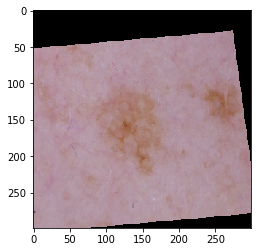

[0. 0. 0. 0. 0. 0. 0. 1.]


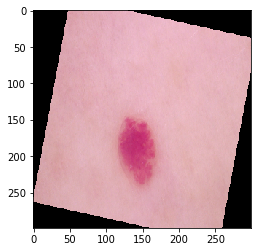

[0. 0. 0. 0. 1. 0. 0. 0.]


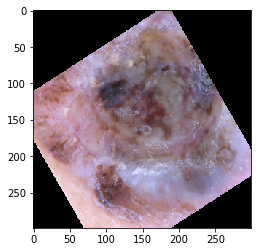

In [25]:
x,y = train_generator.next()
for i in range(0,3):
    image = x[i]
    label = y[i]
    print (label)
    plt.imshow(image)
    plt.show()

## Etapa 3: Construindo o modelo

### Carregando o modelo pré-treinado (InceptionResNetV2)

In [26]:
img_shape = (299, 299, 3)
base_model = tf.keras.applications.InceptionResNetV2(input_shape = img_shape, 
                                               include_top = False,
                                               weights = "imagenet")

219062272/219055592 [==============================] - 6s 0us/step


### Congelando o modelo base

### Definindo o cabeçalho personalizado da rede neural

In [0]:
#base_model.output
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
#global_average_layer
prediction_layer = tf.keras.layers.Dense(units = 8, activation = "softmax")(global_average_layer)

### Definindo o modelo

In [0]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)
#model.summary()

### Compilando o modelo

In [0]:
radam = tfa.optimizers.RectifiedAdam(
    lr=1e-2,
    total_steps=634,
    warmup_proportion=0.1,
    min_lr=1e-5)
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

optm = ranger

In [0]:
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#model.compile(optimizer=tf.keras.optimizers.RMSprop(lr = 0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy()])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.AUC()])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.Recall(thresholds=0.2, class_id=0)])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tf.keras.metrics.SpecificityAtSensitivity(1)])
#model.compile(optimizer=optm, loss="categorical_crossentropy", metrics=[tf.keras.metrics.SpecificityAtSensitivity(1)])
model.compile(optimizer=optm, loss="categorical_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [0]:
checkpoint_filepath = os.path.join(derm_ai_path, 'InceptionResNetV2_cat.weights.best.my.hdf5')

model.load_weights(checkpoint_filepath)

### Treinando o modelo

In [32]:
%%time

checkpoint_filepath = os.path.join(derm_ai_path, 'InceptionResNetV2_cat_train2.weights.best.my.hdf5')

my_checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                 save_best_only=True,
                                                 #monitor='val_specificity_at_sensitivity_1',
                                                 monitor='val_categorical_accuracy',
                                                 verbose=1)

history = model.fit_generator(train_generator, epochs=10, validation_data=valid_generator, callbacks=[my_checkpointer]) #10 ac 5 ss-ac

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 634 steps, validate for 107 steps
Epoch 1/10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
633/634 [============================>.] - ETA: 1s - loss: 0.9544 - categorical_accuracy: 0.6606
Epoch 00001: val_categorical_accuracy improved from -inf to 0.61779, saving model to /content/drive/My Drive/Colab Notebooks/Dermatologist_AI/ISIC_2019/InceptionResNetV2_cat_train2.weights.best.my.hdf5
634/634 [==============================] - 1114s 2s/step - loss: 0.9537 - categorical_accuracy: 0.6608 - val_loss: 1.0020 - val_categorical_accuracy: 0.6178
Epoch 2/10
633/634 [============================>.] - ETA: 1s - loss: 0.7476 - categorical_accuracy: 0.7247
Epoch 00002: val_categorical_accuracy improved from 0.61779 to 0.63899, saving model to /content/drive/My Drive/Colab Notebooks/Dermatologist_AI/ISIC_2019/InceptionResNetV2_c

### Avaliação do modelo de transferência de aprendizagem

In [33]:
valid_loss, valid_acc = model.evaluate_generator(valid_generator)
valid_acc

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


0.6919906

## Etapa 4: Fine tuning


Algumas questões principais:

- NEM SEMPRE é necessário realizar o Fine Tuning em toda a rede neural, pois somente em algumas camadas já é suficiente. A ideia é adotar parte específica da rede neural para nosso problema específico
- Inicie o Fine Tuning DEPOIS que você finalizou a transferência de aprendizagem. Se você tentar o Fine Tuning imediatamente, os gradientes serão muito diferentes entre o cabeçalho personalizado e algumas camadas descongeladas do modelo base 
- Mais informações em como usar o Fine Tuning acesse: 
 https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/

### Descongelando algumas camadas do topo do modelo base

Descomentar trecho abaixo para manter camadas congeladas. O número informado no parâmetro `fine_tuning_at` define o número das primeiras camadas que ficarão congeladas. Supondo que a rede tenha 780 camadas e seja informado o valor 500, até a camada 500 a rede ficará congelada.

In [0]:
#fine_tuning_at = 500
#for layer in base_model.layers[:fine_tuning_at]:
#  layer.trainable = False

### Compilando o modelo para fine tuning

### Fine tuning

### Avaliação do modelo com fine tuning

Text(0.5, 1.0, 'Training and validation loss')

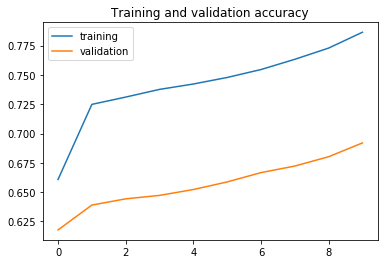

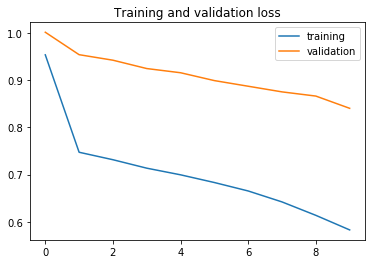

In [35]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

### Salvar modelo após Fine Tuning

In [36]:
%%time
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.

InceptionResNetV2_model_file = os.path.join(derm_ai_path, 'InceptionResNetV2_full_cat_train2.h5')
model.save(InceptionResNetV2_model_file) 

CPU times: user 3.14 s, sys: 811 ms, total: 3.95 s
Wall time: 6.76 s


### Carregar modelo após Fine Tuning com os melhores pesos

In [37]:
%%time

#InceptionResNetV2_model_file = os.path.join(derm_ai_path, 'InceptionResNetV2_full_sp.h5')
#checkpoint_filepath = os.path.join(derm_ai_path, 'InceptionResNetV2_sp.weights.best.my.hdf5')
checkpoint_filepath = os.path.join(derm_ai_path, 'InceptionResNetV2_cat_train2.weights.best.my.hdf5')

# Recreate the exact same model, including its weights and the optimizer
#model = tf.keras.models.load_model(InceptionResNetV2_model_file)
model.load_weights(checkpoint_filepath)

# Show the model architecture
#model.summary()

CPU times: user 948 ms, sys: 271 ms, total: 1.22 s
Wall time: 24.7 s


### Matriz de Validação

In [38]:
# Create a confusion matrix of the test images
val_labels = valid_generator.classes
# Make predictions
val_predictions = model.predict_generator(valid_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


Confusion matrix, without normalization
[[  1  37  31   1  35  59   5   4]
 [ 15 133 129   2 124 233  20   9]
 [ 13 105 104   5  97 178  13  10]
 [  1  11  13   0   7  14   2   0]
 [ 15 171 170  10 177 341  10  10]
 [ 20 173 168   6 193 321  18   5]
 [  1  20  29   1  29  39   6   1]
 [  2  14   4   0  14  15   2   0]]


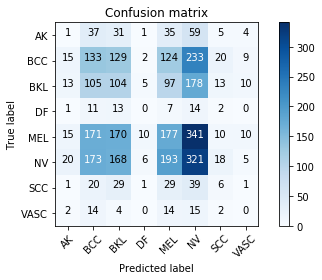

In [39]:
from sklearn.metrics import confusion_matrix

# Declare a function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(val_labels, val_predictions.argmax(axis=1))

cm_plot_labels = ['AK' , 'BCC' , 'BKL' , 'DF' , 'MEL' , 'NV' , 'SCC'	, 'VASC']

plot_confusion_matrix(cm, cm_plot_labels)

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

val_accuracy = 100*np.sum(val_predictions == val_labels)/len(val_predictions)
print('\nTest accuracy: %.2f%%' % val_accuracy)
#

balanced_accuracy = balanced_accuracy_score(val_labels, val_predictions)
print('\nBalanced accuracy: {:.3f}'.format(balanced_accuracy) )


Test accuracy: 0.00%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: ignored

### Execução das predições na base de testes

### Identificar classe predita

In [0]:
def predClasses(pred, train_generator):
  predicted_class_indices=np.argmax(pred,axis=1)

  labels = (train_generator.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  predictions = [labels[k] for k in predicted_class_indices]
  return predicted_class_indices, labels, predictions

predicted_class_indices, labels, predictions = predClasses(pred, train_generator)